In [ ]:
!pip install pyedflib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 10.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyedflib import highlevel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
!wget -r -N -c -np https://physionet.org/files/eegmat/1.0.0/

--2024-07-03 18:12:41--  https://physionet.org/files/eegmat/1.0.0/
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘physionet.org/files/eegmat/1.0.0/index.html’

physionet.org/files     [ <=>                ]   9.10K  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2024-07-03 18:12:42 (139 MB/s) - ‘physionet.org/files/eegmat/1.0.0/index.html’ saved [9320]

Loading robots.txt; please ignore errors.
--2024-07-03 18:12:42--  https://physionet.org/robots.txt
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 22 [text/plain]
Saving to: ‘physionet.org/robots.txt’

physionet.org/robot 100%[===================>]      22  --.-KB/s    in 0s      

2024-07-03 18:12:42 (8.99 MB/s) - ‘physionet.org/robots.txt’ saved [22/22]

--2024-07-03 18:12:

In [ ]:
subject_info = pd.read_csv('/content/physionet.org/files/eegmat/1.0.0/subject-info.csv')

def load_edf_data(file_path):
    signals, signal_headers, header = highlevel.read_edf(file_path)
    return signals

subject_ids = subject_info['Subject'].unique()
data = []
labels = []

max_length = 0
for subject_id in subject_ids:
    baseline_file = f"/content/physionet.org/files/eegmat/1.0.0/{subject_id}_1.edf"
    task_file = f"/content/physionet.org/files/eegmat/1.0.0/{subject_id}_2.edf"
    baseline_signals = load_edf_data(baseline_file)
    task_signals = load_edf_data(task_file)
    data.append(baseline_signals)
    labels.append(0)
    data.append(task_signals)
    labels.append(1)
    max_length = max(max_length, baseline_signals.shape[1], task_signals.shape[1])

padded_data = []
for signals in data:
    if signals.shape[1] < max_length:
        pad_width = max_length - signals.shape[1]
        padded_signals = np.pad(signals, ((0, 0), (0, pad_width)), mode='constant')
    else:
        padded_signals = signals
    padded_data.append(padded_signals)

padded_data = np.array(padded_data)
labels = np.array(labels)

scaler = StandardScaler()
padded_data = scaler.fit_transform(padded_data.reshape(-1, padded_data.shape[-1])).reshape(padded_data.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded_data, labels, test_size=0.2, random_state=42)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(padded_data.shape[1], padded_data.shape[2])),
    MaxPooling1D(2),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(2, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/10
2/2 [==============================] - 16s 7s/step - loss: 1.2131 - accuracy: 0.5263 - val_loss: 5.8240 - val_accuracy: 0.7333
Epoch 2/10
2/2 [==============================] - 9s 5s/step - loss: 1.3059e-05 - accuracy: 1.0000 - val_loss: 5.6668 - val_accuracy: 0.8000
Epoch 3/10
2/2 [==============================] - 10s 4s/step - loss: 0.0104 - accuracy: 1.0000 - val_loss: 6.6369 - val_accuracy: 0.8667
Epoch 4/10
2/2 [==============================] - 11s 5s/step - loss: 9.8295e-08 - accuracy: 1.0000 - val_loss: 7.1870 - val_accuracy: 0.8667
Epoch 5/10
2/2 [==============================] - 6s 3s/step - loss: 3.3462e-08 - accuracy: 1.0000 - val_loss: 7.4759 - val_accuracy: 0.8667
Epoch 6/10
2/2 [==============================] - 8s 3s/step - loss: 1.8823e-08 - accuracy: 1.0000 - val_loss: 7.6104 - val_accuracy: 0.8667
Epoch 7/10
2/2 [==============================] - 10s 6s/step - loss: 1.8823e-08 - accuracy: 1.0000 - val_loss: 7.6824 - val_accuracy: 0.8667
Epoch 8/10
2/2 [=

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

1/1 [==============================] - 0s 440ms/step


In [ ]:
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.71      1.00      0.83         5

    accuracy                           0.87        15
   macro avg       0.86      0.90      0.86        15
weighted avg       0.90      0.87      0.87        15



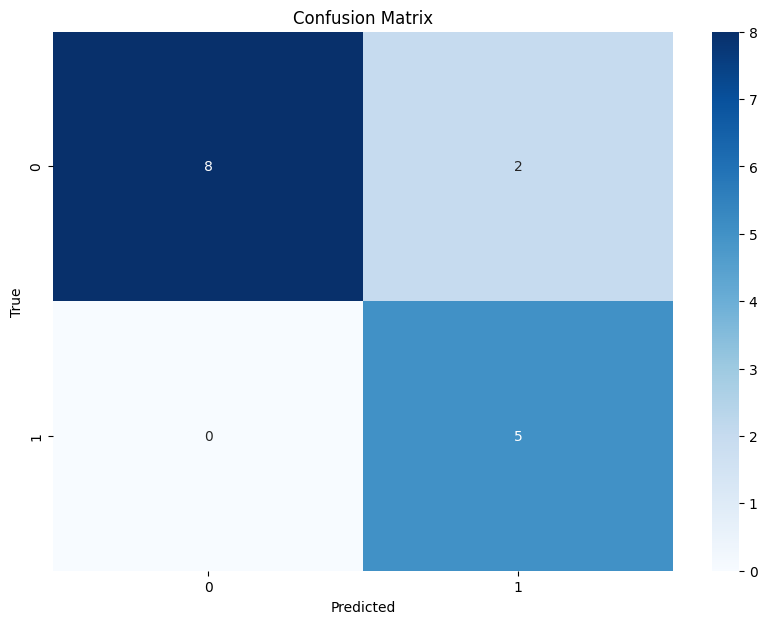

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

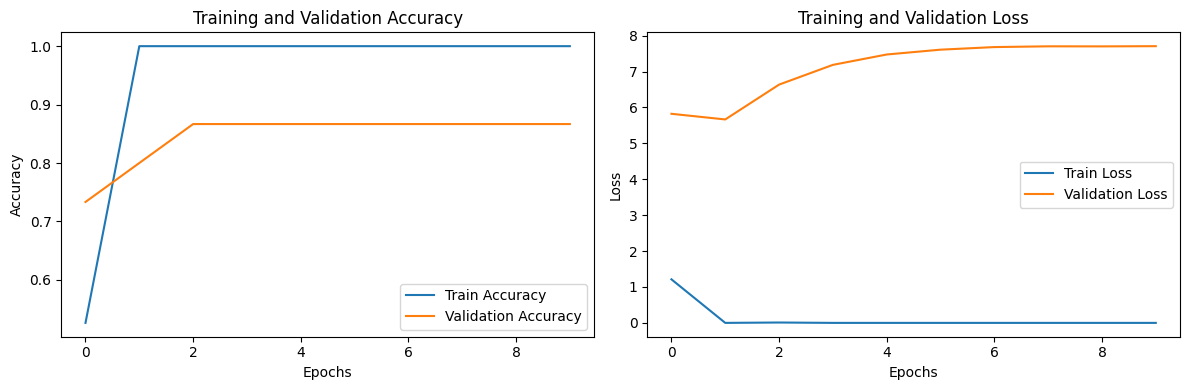

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()